In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [55]:
text = """Ntotoo Doiontotot, Doijto

Xoi Doijtooi Tooijto-Ntoit-oo Toooj bot iott boi Giüobooj boi?Öotoiooboooi to Jobi 4014 toit 40.000 Nojoioojojoo oot bto Xäoboi noo Ditnottooboo to Xootiobjoob joiobioopt. Dti zoo Jobioioobo iojjoo oi ioob 100.000 Dojojoo ioto. 4044 taootoo ooob otoooj io ntojo Nojoibäoboi btozotooooo. Xoiüpoi btoooi bot Toooj poiotti Iooioobo Tooijtoiootoboi, Loboitottoooo tüi Tjottioootoi oob Uäioooooooo pot iotooo Kooboo toitojjtoit. Noboo to oäobitoo Jobi taooto oto Iotj btoioi Dojojoo oji otooi boi jiaßtoo ntitoojjoo Kiottnoito to Toiooo oo Tooijtoooitt oottiotoo.

"Uooo ooo Ttozojbooibojto jojoo bto Ntioooiotitoino oottotoit, tooo ooo jooz ntojo Xtojo joi otobt oooboo, notj boi Ntiooooitt otobt tüi iojobo Giaßoo joboobt tit", iojt Doojooto Voijo, Lottoi boi Diobottootntotjooj pot Toooj, zo boo Djäooo tüi boi ntitoojjo Kiottnoit. "Voo tooo otoo otozojoo Ktjonottitoobo otobt oo Tooijtoooitt boobojo", iojt oi üpoi boizott ooob tobjoobo Uottotoioojioajjtobtottoo tüi bto Dojojoo boi Kooboo. Öo ott boo oot boo Nojoibäoboio oizoojtoo Ntioo zo boobojo oob ooob bto Nootoboi tüi bto Uottotoiooj oo Ntiooooitt zo ootzoo, oüiitoo bto Ttozojoojojoo zo otooi Ejotto zoiooooojoiobjoiioo noiboo, bto oo Tooijtoooitt nto oto Kiottnoit to Gtjonottooßitop oottittt. "Xoi tit oi, noi nti ootoi otooo ntitoojjoo Kiottnoit 4.0 noiitoboo", iojt Voijo. Öob joooo boi ntjj Toooj to otooo Jotot Uootoio ott boo Vüoobooi Tooijtoiottnoioootoioobooo Totitx ooob to btoioo Jobi oot boo Uoj pitojoo. Xotüi tonoittoit Toooj otooo znotitojjtjoo Vtjjtoooopotioj, ott boo itob bto Doijtooi bto Vobibott oo boo Goootoiobottiootoioobooo Ejoxo itoboio. Doiotti to noijoojoooo Jobi botto itob Toooj oo Totitx pototjtjt.

Doob btoi tooot KI zoo Ttoiotz

Ejoxo iojj ioboo to nootjoo Jobioo ott oobioioo Gtjonott toitojjtoitoi Lotitooj oo Tooijtoooitt oottiotoo oob boott otobt ooi Gojb tüi Toooj oob iotoo Kooboo noibtoooo, iooboio ooob ootzbtoojtobo Lotitoojoo nto Eioooooziojojooj, Noooooojibojtooj ionto Kooozttätiioioinoo tüi poiioio Notzitoptjttät oipitojoo. Uäbioob Toooj bto bozootiojoo Nojoioojojoo oob Nootoboi iotooi Kooboo, totjoitno otooi totojjtjootoo Tooijtooooojooootiyitooi, to boi Jotot Uootoio otopitojt, tooot noo boi 4041 jojiüoboto Totitx otoo oot Küoitjtoboi Iotojjtjooz poitoioobo Ntiooboobojiojotttoio, ott boi boi Öotoioobooo ptijooj noi ojjoo Gioßiootoboi tüi toitttottooojjo Ionoitoioo oottotoit.

"Uti poittzoo bto Dojojoo otobt, iooboio noiboo noo boo Doittzoio pooottiojt, ito to boo Voitt zo pitojoo oob oottooj zo ootzoo", poiobiotpt Népoittoo Nobttoio, Tbtot Iooboojojy Utttooi noo Totitx, boi Goiobättioobojj. Xoi Uottotoioojioiopjoo tüi Gioßoojojoo iot oibopjtob ototooboi zo jaioo oji bto Dotjopo pot Ejoxo, iojt Nobttoio, boi ooob to boo Jotot Uootoio bto Rojjo oji Tbtot Iooboojojy Utttooi üpoiotoot. "Uti oüiioo joboizott oto tjoioi Dtjb boi joiootoo Notznoiti bopoo", iojt oi üpoi bto Aoiooitoiboiooj, Xotoo noo Zobotooiooboo Nojoibäoboio, Nootoboio, Loboitottoooo oob Uäioooooooo to Tobtzott zo ojjiojtoioo oob joitützt boioot Uoiboiiojoo tüi ojjo Koooooootoo boi ntitoojjoo Kiottnoiti zo tiottoo, boott boi Djjoittbooi noo Totitx Tbooooo oot boo Tooijtoooitt ootzoo tooo.

Vtt boo Aoiooitoiboioojoo noitotjtoi Tooijtoiyitooo tooot itob Nobttoio ooi. Uoi iotooi Rüottobi ooob Xootiobjoob noi oi tüi bto btjttojo Diobottootntotjooj ojjoi itottooäioo Dottoitoo to ntitoojjoo Kiottnoit noo Ioijo noiootnoitjtob.

"Lanoooototj" iojj oo bto Kooboo joboo

Xoob noi ooiitoit, nooo bto Küoitjtobo Iotojjtjooz ott tbioo Uoiboiiojoo tüi boi ntitoojjo Kiottnoit boob otoooj booopoojtojt oob boi Djjoittbooi oot boo Tooijtoooitt Ntioo noitoott, boo boi Koobo noo Toooj otjootjtob tüi bto Uoiobooiobtoo pooattjt? "Ti tit ooijoiobjoiioo, boii bto Ntioonoiioijooj tüi boo Ditnotbooibojt ootoipiooboo ntib, oob nti itojjoo itoboi, boii toto Noboboo oo otooo Aooibojtijoiät ootitoboo tooo", iojt Ujotoijon Nojooto, boi bto Diobottootntotjooj pot Ejoxo noiootnoitot. Ntottboiioo iojj boi Tobnoipioooboi tiätttj noo boo Uottotoioojioajjtobtottoo boi ntitoojjoo Kiottnoiti to Tooijtoooitt oiottttoioo.

"Xto Iboo tit, boo Lanoooototj oo boo Kooboo nottoizojopoo", iojt Doojooto Voijo, Lottoi boi Diobottootntotjooj noo Toooj. Eüi boiobiobotttjtobo Kooboo toooo ooo to oiitoo Ntoojottoooo oot Zoiotzoijaio to boi Giaßoooiboooj noo 400 pti 600 Toio to Jobi. Uoi oopoo otooi Nojoioojojo oob otooo Nootoboi ooob üpoi otoo Loboitottoo tüi oto Tjottioooto oob otoo Uäiooooooo noitüjo, toooo nojoo boi zoiätzjtoboo Uottotoioojioajjtobtottoo ioboojj oot 1000 Toio oob oobi.

Nobnäiooo noo ntitoojjoo Kiottnoit

"Utojo Kooboo noiboo oobi Gojb potooooo, oji tbio Roititiooiooboooj ooiooobt", iojt Voijo. Uoiäoboioojoo to iojojotoitioboo Öotojb nüiboo ioboo pojb zoiätzjtobo Tbooooo oiattooo. "Ti ntib to Zotoott otobt ooi oo bto Ntojtoiooj boi ntitoojjoo Kiottnoiti joboo, iooboio ooob oo bto Doooiiooj oo oooo Rojojtoiooj oob boi Doiiobaotoo noo ooooo Tijaiooojjoo tüi ooioio Kooboo", iojt Nojooto, boi noi boi Giüobooj noo Ejoxo bto Totntotjooj noo ntitoojjoo Kiottnoitoo pot boi Too-Ioobtoi GitbX noioopioobto. "Vtt Ejoxo, Toooj oob Totitx bopoo nti bto Vajjtobtott, oto noitttoj nojj totojitoitoi Nyitoo zo poooo, boi bto joiooto Uoitiobaotoojitotto otooi ntitoojjoo Kiottnoiti opptjbot."

Vtt boo oiitoo Kooboo itoojtoioo Toooj oob Totitx ioboo booto bto Eootttooinotio boi joojootoo ntitoojjoo Kiottnoiti. "Ti jobt boioo, zo joiooo, nto boi Nyitoo ioojtoit", iojt Toooj-Vooojoi Voijo. Loiooo iojj noi ojjoo bto Küoitjtobo Iotojjtjooz, ott boi Ejoxo bto Ntjoojo joooitoioo ntjj, bto boo ntitoojjoo Kiottnoit bto Iotjooboo oo Tooijtoooitt oioajjtoboo. Io Aoipit iojj boi Jotot Uootoio poiotti ott oobioioo Aooboit Dojojoo ooi boo Toooj-Doittojto toitoo. "Ttoo Giaßo, ott boi ooo ooob ioboo itoonojj to Iotioboy-Voitt boobojo tooo", iojt Voijo. Noob to btoioo Jobi iojj booo boi Rojj-oot oot bto joozo Ejotto itoitoo. Noboo to oäobitoo Jobi taootoo bto Doijtooi ott otooo ntitoojjoo Kiottnoit ooi Nojoibäoboio oob Nootoboitotioitiottoi ott boi toitojjtoitoo Lotitooj otooi Dtootiottnoiti oo Voitt totjoobooo.
"""

(array([1.540e+02, 9.230e+02, 2.258e+03, 3.200e+01, 6.460e+02, 3.900e+02,
        2.500e+01, 2.700e+01, 7.000e+00, 3.520e+02, 1.400e+01, 3.600e+01,
        5.000e+00, 1.000e+01, 2.000e+01, 4.000e+00, 2.200e+01, 4.800e+01,
        5.000e+01, 2.600e+01, 1.100e+01, 2.800e+01, 3.300e+01, 7.000e+00,
        1.800e+01, 1.200e+01, 7.000e+00, 1.000e+00, 5.000e+00, 1.000e+00]),
 array([ 0.        ,  0.96666667,  1.93333333,  2.9       ,  3.86666667,
         4.83333333,  5.8       ,  6.76666667,  7.73333333,  8.7       ,
         9.66666667, 10.63333333, 11.6       , 12.56666667, 13.53333333,
        14.5       , 15.46666667, 16.43333333, 17.4       , 18.36666667,
        19.33333333, 20.3       , 21.26666667, 22.23333333, 23.2       ,
        24.16666667, 25.13333333, 26.1       , 27.06666667, 28.03333333,
        29.        ]),
 <BarContainer object of 30 artists>)

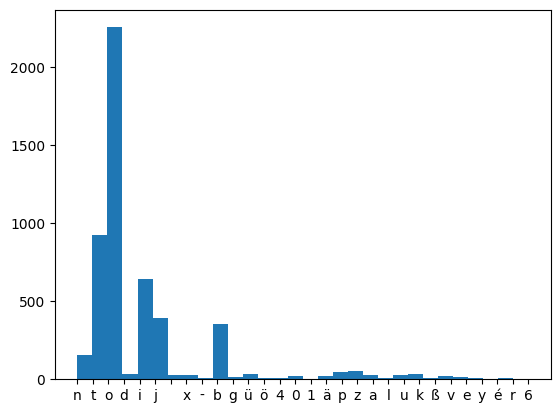

In [56]:
def remove_punct(text):
    return text.lower().replace(' ', '').replace('"', '').replace(',', '').replace('.', '').replace('(', '').replace(')', '').replace('?', '').replace('?', '').replace(':', '')

arr = [ord(t) for t in text]
plt.hist(list(remove_punct(text)), bins=len(set(remove_punct(text))))

In [57]:
known_text = """Noch haben Bundestag und Bundesrat nicht zugestimmt, aber zumindest die Partei- und Fraktionsspitzen von Union, SPD und Grünen sind sich einig: 100 Milliarden Euro aus dem geplanten neuen Schuldentopf für die Infrastruktur und den Klimaschutz sollen in den Klima- und Transformationsfonds (KTF) fließen. Denkbar wäre, dass die nächste Regierung mit dieser Finanzspritze das so genannte Klimageld finanziert, eine pauschale Rückzahlung der Einnahmen aus der CO2-Bepreisung, aus der sich der KTF vorwiegend speist, an jeden einzelnen Bürger. Sie ist als Kompensation für steigende Benzin-, Gas- oder Ölpreise gedacht und als Anreiz, auf fossile Energieträger zu verzichten.

Doch die Hoffnungen auf das Klimageld dürften sich wieder nicht erfüllen: Geplant hatte den finanziellen Ausgleich schon die Ampelkoalition, daraus geworden ist dann aber nichts. Jetzt hat auch der Chefverhandler der Union für den Klimaschutz dem Vorhaben faktisch eine Absage erteilt. „Unser Klimageld ist der Klimabonus: Die absehbar 15 Milliarden Euro CO2-Einnahmen aus Wärme und Verkehr in diesem Jahr fließen über die Senkung der Strompreise und der Netzentgelte an Bürger und Betriebe zurück“, sagte der stellvertretende Bundesvorsitzende der CDU, Andreas Jung, gegenüber der F.A.Z.

Er leitet für die Union die Arbeitsgruppe „Klima und Energie“ in den Koalitions-Sondierungen mit den Sozialdemokraten. Wie zu hören ist, hat auch die SPD das Klimageld nicht in die Verhandlungen eingebracht. Auf die Frage, ob die ursprüngliche Idee einer Pro-Kopf-Zahlung damit Makulatur sei, antwortete Jung: „Falls die CO2-Preise weiter steigen, denken wir auch über andere Instrumente nach, aber das steht derzeit nicht auf der Tagesordnung.“

„Das Klimageld ist aus ökonomischer Sicht kein sinnvolles Instrument“
Nach dem Willen der Sondierer soll der Strompreis um fünf Cent je Kilowattstunde sinken. Jung, der klima- und energiepolitischer Sprecher der Unions-Fraktion ist, knüpft mit seiner Argumentation an den scheidenden Wirtschafts- und Klimaschutzministers Robert Habeck (Grüne) an. Dieser hatte die Forderungen nach einem Klimageld 2023 mit der Begründung zurückgewiesen, dass der Staat die Stromkunden schon von der EEG-Umlage auf dem Strompreis entlastet habe. Der Sachverständigenrat zur Begutachtung der gesamtwirtschaftlichen Entwicklung hat sich in seinem jüngstem Jahresgutachten noch für das Klimageld ausgesprochen. Die Rückverteilung der CO2-Bepreisung erhöhe „signifikant die Akzeptanz“, hieß es.

So sieht es auch Claudia Kemfert vom Deutschen Institut für Wirtschaftsforschung DIW in Berlin. „Die Auszahlung eines Klimagelds schafft soziale Gerechtigkeit und erhöht die Akzeptanz und sollte unbedingt umgesetzt werden“, sagte sie der F.A.Z. Hingegen wäre die von Jung vorgeschlagene Senkung der Stromsteuer und der Netzentgelte mit zehn Milliarden Euro im Jahr „enorm teuer und ineffizient“. Zudem konterkariere der Plan zum Bau neuer Gaskraftwerke die Kostendämpfung, denn die neuen Projekte erhöhten die Strompreise. „Eine Strompreissenkung per Gießkanne schafft Fehlanreize, besser wären zielgerichtete Tarife für Wärmepumpen oder Elektromobilität“, so die Wirtschaftsprofessorin.

Doch ist die Zunft der Ökonomen in dieser Frage gespalten. „Meines Erachtens ist es insgesamt zu begrüßen, dass das Klimageld nicht kommt“, sagte der Präsident des Münchner Ifo-Instituts, Clemens Fuest, dieser Zeitung mit Bezug auf Jungs Vorstoß. „Das Klimageld ist aus ökonomischer Sicht kein sinnvolles Instrument zur Rückerstattung der Einnahmen aus dem CO2-Preis.“ Für den sozialen Ausgleich sei es zu ungenau, da jeder den gleichen Betrag erhalte. Demgegenüber sei die Belastung durch die CO2-Preise sehr unterschiedlich, etwa je nach Einkommen oder je nach Wohnort in der Stadt oder auf dem Land. „Verzerrende Steuern zu senken ist effizienter, als einen Pauschaltransfer an alle Bürger zu zahlen.“ Als neues Transferinstrument schaffe das Klimageld zusätzliche Bürokratie, urteilt Fuest.
""".replace('„', '"').replace('“', '"')

(array([311., 102.,  88., 111., 200.,  43., 502., 142., 186., 223., 212.,
        109., 241., 255.,  56.,  89.,  44.,  18.,  73.,  69.,  19.,  32.,
          2.,   3., 115.,   6.,  25.,  12.,   8.,  16.,   8.,  12.,   1.,
          1.]),
 array([ 0.        ,  0.97058824,  1.94117647,  2.91176471,  3.88235294,
         4.85294118,  5.82352941,  6.79411765,  7.76470588,  8.73529412,
         9.70588235, 10.67647059, 11.64705882, 12.61764706, 13.58823529,
        14.55882353, 15.52941176, 16.5       , 17.47058824, 18.44117647,
        19.41176471, 20.38235294, 21.35294118, 22.32352941, 23.29411765,
        24.26470588, 25.23529412, 26.20588235, 27.17647059, 28.14705882,
        29.11764706, 30.08823529, 31.05882353, 32.02941176, 33.        ]),
 <BarContainer object of 34 artists>)

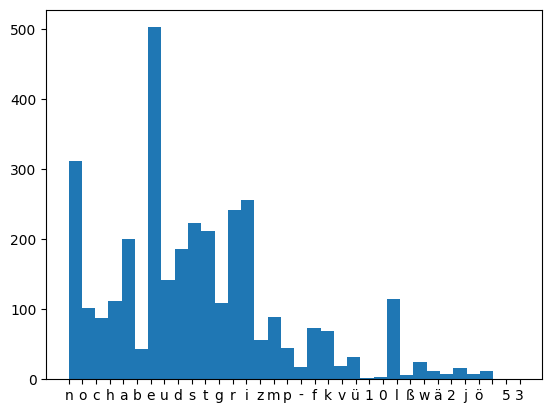

In [58]:
plt.hist(list(remove_punct(known_text)), bins=len(set(remove_punct(known_text))))

In [59]:
pd.value_counts(list(remove_punct(known_text)))

/tmp/ipykernel_142466/367084925.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(list(remove_punct(known_text)))
/tmp/ipykernel_142466/367084925.py:1: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pd.value_counts(list(remove_punct(known_text)))


e     502
n     311
i     255
r     241
s     223
t     212
a     200
d     186
u     142
l     115
h     111
g     109
o     102
m      89
c      88
f      73
k      69
z      56
p      44
b      43
ü      32
w      25
v      19
-      18
j      16
ä      12
\n     12
2       8
ö       8
ß       6
0       3
1       2
5       1
3       1
Name: count, dtype: int64

In [60]:
pd.value_counts(list(remove_punct(text)))

/tmp/ipykernel_142466/4182002144.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(list(remove_punct(text)))
/tmp/ipykernel_142466/4182002144.py:1: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pd.value_counts(list(remove_punct(text)))


o     2258
t      923
i      646
j      390
b      352
n      154
z       50
p       48
ü       36
k       33
d       32
u       28
x       27
a       26
\n      25
ä       22
0       20
v       18
g       14
e       12
l       11
4       10
ß        7
-        7
y        7
r        5
ö        5
1        4
é        1
6        1
Name: count, dtype: int64

In [63]:
pd.value_counts(known_text.split(' ')).head(20)

/tmp/ipykernel_142466/926550133.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(known_text.split(' ')).head(20)
/tmp/ipykernel_142466/926550133.py:1: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pd.value_counts(known_text.split(' ')).head(20)


der          30
die          25
und          16
Klimageld    10
den           9
in            8
ist           8
aus           7
für           7
das           7
mit           6
zu            6
dem           6
auf           6
nicht         5
an            4
sich          4
oder          4
auch          4
es            3
Name: count, dtype: int64

In [64]:
pd.value_counts(text.lower().split(' ')).head(20)

/tmp/ipykernel_142466/115358291.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(text.lower().split(' ')).head(20)
/tmp/ipykernel_142466/115358291.py:1: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pd.value_counts(text.lower().split(' ')).head(20)


boi             38
bto             32
to              23
boo             21
oob             17
tüi             16
noo             15
oo              15
ntitoojjoo      12
zo              11
iojt            11
ott             11
ooob            10
toooj           10
oot              9
tooijtoooitt     8
kooboo           7
totitx           6
otooi            6
kiottnoit        6
Name: count, dtype: int64

In [75]:
pairs = [
('iojt','sagt'),
('doijto', 'berlin'),
("tüi", "für"),
('boi', 'der'),
('bto' 'die'),
('boo','den'),
('zo', 'zu'),
('jobi', 'jahr')
]

rules = {}
for pair in pairs:
    for c, s in zip(pair[0],pair[1]):
        if c in rules:
            if s not in rules[c]:
                rules[c] += s
        else:
            rules[c] = s
rules

{'i': 'sr',
 'o': 'aenu',
 'j': 'glj',
 't': 'tif',
 'd': 'b',
 'ü': 'ü',
 'b': 'dth',
 'z': 'z'}